<a href="https://colab.research.google.com/github/ColeHenson/Data-Science24-25/blob/main/Cole_HensU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5 Project: Predicting the total scores in Nba games with the expected outcomes according to betting markets



# Data

Sports betting is becoming an increasingly large industry increasing from roughly \$400 million to \$11 billion in market capitalization from 2018 to 2023. The allur to sports betting is in part the connection it has to the cultural phenomenon of sports. But, also the feeling of control people have over their chances of profiting in contrast to some more traditional forms of gambling like slot machines. Much like in the case of day trading, gamblers feel that if they become experts in sport subject matter, they can profit off the information they have on the market. Also much like day traders, the vaste majority of them lose money. One type of sports betting is over under betting on the total score of a game. The way this works is that a sports betting company, usually with the use of a predictive model estimates the median score for a game. If they are accurate their predictions should be very informative about the actual scores of the game. However, the predicitons are also likely to always fail to predict outliers that are inherently unlikely.

My personal interest in sports betting is derived from my interest in betting market's predictive power rather than my interest in involving myself in gambling. The profitability of the stock market suggests that the economy we live in places a premium on information reguarding the future and I beleive betting markets serve as a powerful test of people's overconfidence bias. In theory the over under is the median score and the house wouldn't create it unless it is profitable. Thus there is no difference between sports betting and slot machines unless the house fails to find the true median total points.

The data was found on the ufl page linked in the class repo.

# Linear Model

In [24]:
#import statments from the notes.
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator
#copied data from ufl into my github
Odds_Data = pd.read_csv('https://raw.githubusercontent.com/ColeHenson/Data-Science24-25/refs/heads/main/nbaodds201415.csv')
Odds_Data

,Datenum,Team,Dateslash,OppTeam,Home,TeamPts,OppPts,OT,TeamWin,TeamCov,TeamSprd,OvrUndr,OUCov,Team_id,OppTeam_id,TeamDiff,TotalPts
0,42104,Utah,4/10/2015,Memphis,1,88,89,0,0,1,2.5,175.5,1,29,15,-1,177
1,42073,Utah,3/10/2015,New York,1,87,82,0,1,-1,-13.0,179.0,-1,29,20,5,169
2,41962,Indiana,11/19/2014,Charlotte,1,88,86,0,1,0,-2.0,179.5,-1,12,4,2,174
3,41958,Chicago,11/15/2014,Indiana,1,90,99,0,0,-1,-9.0,180.5,1,5,12,-9,189
4,42088,Utah,3/25/2015,Portland,1,89,92,0,0,-1,-2.0,180.5,1,29,25,-3,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,42104,Oklahoma City,4/10/2015,Sacramento,1,116,103,0,1,-1,-13.5,219.5,-1,21,26,13,219
1226,42027,Phoenix,1/23/2015,Houston,1,111,113,0,0,-1,-2.5,220.5,1,24,11,-2,224
1227,41966,L.A. Lakers,11/23/2014,Denver,1,94,101,1,0,-1,1.5,221.0,-1,14,8,-7,195
1228,42029,Phoenix,1/25/2015,L.A. Clippers,1,100,120,0,0,-1,2.5,223.0,-1,24,13,-20,220


<Axes: xlabel='OvrUndr', ylabel='TotalPts'>

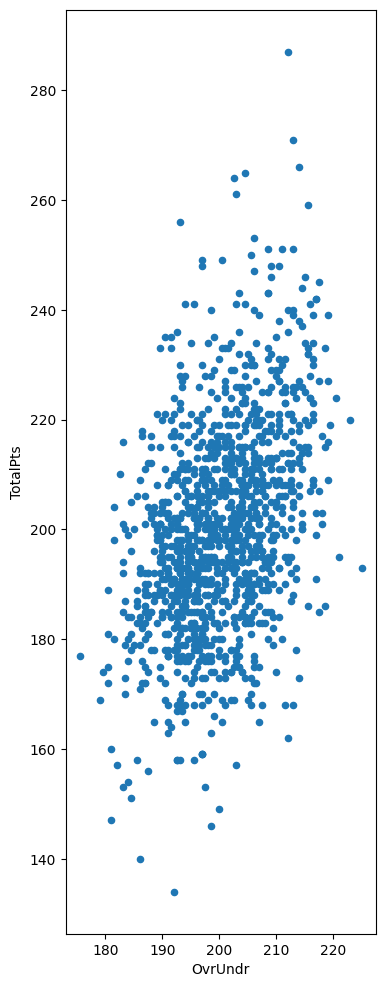

In [25]:
# plot data
# set figsize to try to scale x and y axes
Odds_Data.plot(x="OvrUndr", y="TotalPts", figsize=(4, 12), kind="scatter")

Just eye balling the data, it looks like I have a positive correlation between OvrUndr which is what I would expect. Also worth noting, the range of the true values of basketball game scores is much higher than the range of the OvrUndr, this is because the OvrUndr is trying to find the most likely scores for each game not the most likely distribution of scores accross all games in the nba season. Also worth noting, it seems like a LSRL would have a very high slope indicating a small increase in Ovr Undr predicts a larger increase in total points. That said, I am not a computer and don't actualy know what the LSRL would look like right now. It also appears that the OvrUndr is only weakly predictive of the total score.

In [26]:
#model total scores
#skeleton copied from U5 notes AK
with pm.Model() as model_pts:

    #priors for the linear part of our model
    # normal because I expect the distribution to be roughly normal
    # slope mu is 1 because I don't know that the slope will be and can be +/-
    # sigma is 10
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=1, sigma=10)

    #this is the linear part of our model
    #I am assuming there is a strictly linear relationship between the ovrundr
    #and the actual results
    #ovrundr is the outcome expected by the sports betting company
    μ = pm.Deterministic("μ", α + β * Odds_Data.OvrUndr)

    #likelihood
    # Poisson because I am trying to predict the number of points that are
    # scored within the set timeframe of a single game
    y_pred = pm.Poisson("y_pred", mu=μ, observed=Odds_Data.TotalPts)

    #inference data object
    idata_pts = pm.sample()



Output()

Output()

I originally wanted to use a normal distribution as my likelyhood because I thought the data would follow a normal distribution curve; however, the true number of points in any given game is a discrete value rather than a continuous one so I decided to use a poisson distribution.

For my priors, I don't really know that much about betting markets but I expect to have a positive slope for the linear part of my model. I am using a poisson because I am trying to predict the number of times points are scores in the set time frame of a game.

Text(0, 0.5, 'TotalPts')

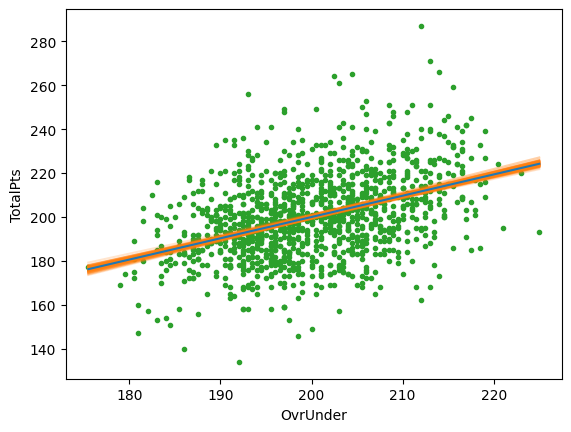

In [27]:
# skeleton copied from u5 AK notes
posterior = az.extract(idata_pts, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(Odds_Data.OvrUndr.min(), Odds_Data.OvrUndr.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict overunder and
#totalpts deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(Odds_Data.OvrUndr, Odds_Data.TotalPts, "C2.", zorder=-3)

#label axes and create legend
#we are using ovrunder to predict total points although ovrunder in no way
#causes or influences the total pts value
#i could just as well have gone the other way although
#Mr. A agreed I should predict the ovrunder with the total points after
#some deliberation
ax.set_xlabel("OvrUnder")
ax.set_ylabel("TotalPts")


The slope of these lines actually pretty close to one. Which would suggest an increase by one point in the OvrUnder predicts an increase in the total points by one. The model appears to have captured a weak positive trend because there is no line that has a negative or flat slope.

In [28]:
# posterior predictive sample
pm.sample_posterior_predictive(idata_pts, model=model_pts,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'TotalPts')

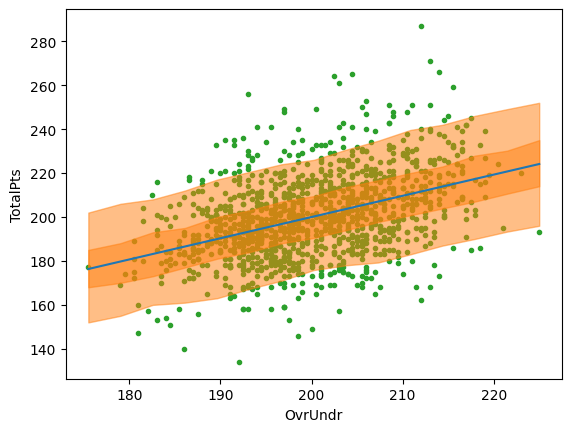

In [29]:

#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_pts.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
OvrUndrs = np.random.normal(Odds_Data.OvrUndr.values, 0.01)
idx = np.argsort(OvrUndrs)
x = np.linspace(OvrUndrs.min(), OvrUndrs.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_pts.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(OvrUndrs[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(Odds_Data.OvrUndr, Odds_Data.TotalPts, "C2.", zorder=-3)
ax.plot(Odds_Data.OvrUndr[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("OvrUndr")
ax.set_ylabel("TotalPts")

There is a lot of data that falls outside the distribution probably because the ovrundr is really not that precise prediction of the actual results and fails to predict unlikely results. Thee is a clear positive

<Axes: xlabel='y_pred'>

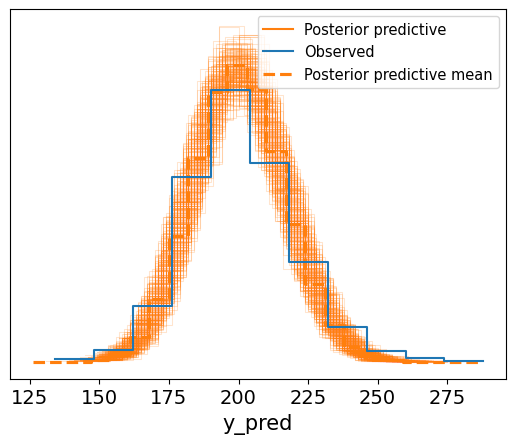

In [30]:
# plot predictive posterior curve
az.plot_ppc(idata_pts, num_pp_samples=200, colors=["C1", "C0", "C1"])


Mean and median are roughly 200 pts. Standard devation looks like about 25 points. Range is 150 points.

The predictive posterior fits the observed data pretty well in so I think this model is a good fit. There are no negative values since I used a Poisson and the shape and mode fit the data well. I would expect this because I am using a data set that is intentionally trying to predict the true values of a basketball game. The actual data presents a slightly higher probabability of extreme values of total points within games which I would expect because the prior uses predicted median scores for games which is likely to be close to the mean values. I know the 538 political model generates a bunch of different predictions for what the true value would be and thus captures outlier results. I suspect the betting market does a similar thing and the over under is a mean or median of distribution of results. The betting market model probably uses past results to predict future results. However, their models will never be perfect as basketball and the teams that play it change over time.

# Remove OT

I decided to continue by removing all the games that go into overtime from the data set so the amount of time per game is the same

In [31]:
rmvot = pd.DataFrame(Odds_Data)
rmvot = rmvot[rmvot['OT']!=1]
rmvot

,Datenum,Team,Dateslash,OppTeam,Home,TeamPts,OppPts,OT,TeamWin,TeamCov,TeamSprd,OvrUndr,OUCov,Team_id,OppTeam_id,TeamDiff,TotalPts
0,42104,Utah,4/10/2015,Memphis,1,88,89,0,0,1,2.5,175.5,1,29,15,-1,177
1,42073,Utah,3/10/2015,New York,1,87,82,0,1,-1,-13.0,179.0,-1,29,20,5,169
2,41962,Indiana,11/19/2014,Charlotte,1,88,86,0,1,0,-2.0,179.5,-1,12,4,2,174
3,41958,Chicago,11/15/2014,Indiana,1,90,99,0,0,-1,-9.0,180.5,1,5,12,-9,189
4,42088,Utah,3/25/2015,Portland,1,89,92,0,0,-1,-2.0,180.5,1,29,25,-3,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,41978,Boston,12/5/2014,L.A. Lakers,1,113,96,0,1,1,-3.0,219.0,-1,2,14,17,209
1225,42104,Oklahoma City,4/10/2015,Sacramento,1,116,103,0,1,-1,-13.5,219.5,-1,21,26,13,219
1226,42027,Phoenix,1/23/2015,Houston,1,111,113,0,0,-1,-2.5,220.5,1,24,11,-2,224
1228,42029,Phoenix,1/25/2015,L.A. Clippers,1,100,120,0,0,-1,2.5,223.0,-1,24,13,-20,220


In doing this I fully expect to see pretty much the exact same results

In [32]:
#same as before but with new data
Odds_Data = rmvot
with pm.Model() as model_pts_not:

    #priors for the linear part of our model
    # normal because I expect the distribution to be roughly normal
    # slope mu is 1 because I don't know that the slope will be and can be +/-
    # sigma is 10
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=1, sigma=10)

    #this is the linear part of our model
    #I am assuming there is a strictly linear relationship between the ovrundr
    #and the actual results
    #ovrundr is the outcome expected by the sports betting company
    μ = pm.Deterministic("μ", α + β * Odds_Data.OvrUndr)

    #likelihood
    # Poisson because I am trying to predict the number of points that are
    # scored within the set timeframe of a single game
    y_pred = pm.Poisson("y_pred", mu=μ, observed=Odds_Data.TotalPts)

    #inference data object
    idata_pts_not = pm.sample()


Output()

Output()

<Axes: xlabel='y_pred'>

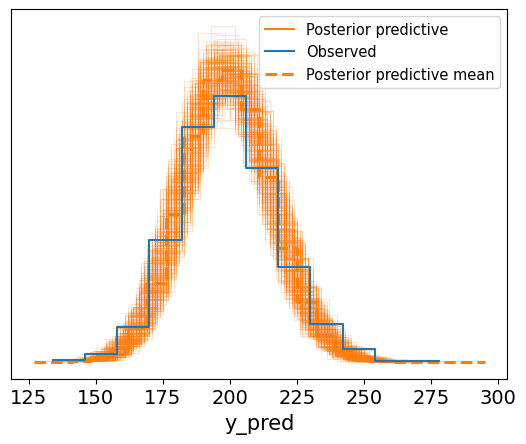

In [39]:
# plot predictive posterior curve
az.plot_ppc(idata_pts_not, num_pp_samples=200, colors=["C1", "C0", "C1"])

As I expected there is pretty much no tangible difference between the results when I include or exclude the OT games. If anything the OT game model is a little better.